# MLB Stadium Tour

## 1 Overview

This workbook explores an algorithm that optimizes the best route to take in order to see a baseball game at every MLB stadium. The goal is to minimize the number of miles driven as well as the number of days on the trip, given a predefined set of constraints and parameters

## 2 Assumptions

To solve this problem we need to make a number of assumptions.

1. We are minimizing miles between ballparks and are not considering road or traffic data. We will assume that less miles between ballparks is equivalent to shorter drives.
2. We will assume all games that are scheduled are going to be played. In other words, we cannot predict rainouts. We do, however, know which stadiums are either domes or have retractable roofs, and we have access to historical rain probabilities by day and by city.
3. We will ignore doubleheaders and always choose the earlier game on a particular day. Of course it's possible to catch a Mets game in the early afternoon and a Yankees game at night, but we will assume that's too much baseball in one day for any sane person. It's also difficult to predict how long a game will go (i.e., extra innings), so assuming a max of 1 game per day is probably the safer bet.

## 3 Getting the Data

The following sources will be used:

1. Stadium data
2. MLB Schedule data (Baseball Reference)
3. Historical Weather data (National Climatic Data Center)

### 3.0 Import Libraries

First, let's import all python libraries that are necessary to run any future code.

In [1]:
# Import the appropriate libraries
from bs4 import BeautifulSoup
import requests
import datetime as dt
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import geopandas as gpd
import seaborn as sns
import os
import time

pd.options.display.max_columns = 100

### 3.1 Stadium Data

We will start by creating a dataframe that contains information about each ballpark. Most notably, it will contain the latitude and longitude of each ballpark so that the distances between parks can be easily calculated in the algorithm. These will also be used to find the closest weather station to each park as well as help us to create a map of the final route. Another critical piece here are the region clusters which will be used in the algorithm

In [2]:
# Create DataFrame of stadium info
stadiums = [
    ["Los Angeles Angels","Angel Stadium of Anaheim","2000 Gene Autry Way, Anaheim, CA. 92806",33.799572,-117.889031,'Pacific'],
    ["Arizona D'Backs","Chase Field","P.O. Box 2095, Phoenix, AZ. 85001",33.452922,-112.038669,'Pacific'],
    ["Atlanta Braves","SunTrust Park","P.O. Box 4064, Atlanta, GA. 30302",33.74691,-84.391239,'Southeast'],
    ["Baltimore Orioles","Oriole Park at Camden Yards","333 W. Camden Street, Baltimore, MD. 21201",39.285243,-76.620103,'Northeast'],
    ["Boston Red Sox","Fenway Park","4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,'Northeast'],
    ["Chicago Cubs","Wrigley Field","1060 Addison Street, Chicago, IL 60616",41.947201,-87.656413,'Midwest'],
    ["Chicago White Sox","Guaranteed Rate Field","333 W. 35th Street, Chicago, IL 60616",41.830883,-87.635083,'Midwest'],
    ["Cincinnati Reds","Great American Ball Park","100 Cinergy Field, Cincinnati, OH 45202",39.107183,-84.507713,'Midwest'],
    ["Cleveland Guardians","Progressive Field","2401 Ontario Street, Cleveland, OH 44115",41.495149,-81.68709,'Midwest'],
    ["Colorado Rockies","Coors Field","2001 Blake Street, Denver, CO 80205-2000",39.75698,-104.965329,'Rocky Mountains'],
    ["Detroit Tigers","Comerica Park","2100 Woodward Ave., Detroit, MI 48201",42.346354,-83.059619,'Midwest'],
    ["Miami Marlins","Marlins Park","2269 NW 199th Street, Miami, FL 33056",25.954428,-80.238164,'Southeast'],
    ["Houston Astros","Minute Maid Park","P.O. Box 288, Houston, TX 77001-0288",29.76045,-95.369784,'Southwest'],
    ["Kansas City Royals","Kauffman Stadium","P.O. Boz 419969, Kansas City, MO 64141",39.10222,-94.583559,'Midwest'],
    ["Los Angeles Dodgers","Dodger Stadium","1000 Elysian Park Ave., Los Angeles, CA 90012",34.072437,-118.246879,'Pacific'],
    ["Milwaukee Brewers","Miller Park","P.O. Box 3099, Milwaukee, WI 53201-3099",43.04205,-87.905599,'Midwest'],
    ["Minnesota Twins","Target Field","501 Chicago Ave. S., Minneapolis, MN 55415",44.974346,-93.259616,'Midwest'],
    ["Washington Nationals","Nationals Park","1500 South Capitol Street SE, Washington, DC",38.87,-77.01,'Northeast'],
    ["New York Mets","Citi Field","Roosevelt Ave & 126th Street, New York, NY 11368",40.75535,-73.843219,'Northeast'],
    ["New York Yankees","Yankee Stadium","E. 161 Street & River Ave., New York, NY 10451",40.819782,-73.929939,'Northeast'],
    ["Oakland Athletics","Oakland Coliseum","700 Coliseum Way, Oakland, Ca 94621-1918",37.74923,-122.196487,'Pacific'],
    ["Philadelphia Phillies","Citizens Bank Park","P.O. Box 7575, Philadelphia, PA 19101",39.952313,-75.162392,'Northeast'],
    ["Pittsburgh Pirates","PNC Park","600 Stadium Circle, Pittsburgh, PA 15212",40.461503,-80.008924,'Northeast'],
    ["St. Louis Cardinals","Busch Stadium","250 Stadium Plaza, St. Louis, MO 63102",38.629683,-90.188247,'Midwest'],
    ["San Diego Padres","Petco Park","P.O. Box 2000, San Diego, CA 92112-2000",32.752148,-117.143635,'Pacific'],
    ["San Francisco Giants","Oracle Park","24 Willie Mays Plaza, San Francisco, CA 94107",37.77987,-122.389754,'Pacific'],
    ["Seattle Mariners","T-Mobile Park","P.O. Box 41000, 411 First Ave. S., Seattle, WA 98104",47.60174,-122.330829,'Pacific'],
    ["Tampa Bay Rays","Tropicana Field","1 Tropicana Drive, St. Petersburg, FL 33705",27.768487,-82.648191,'Southeast'],
    ["Texas Rangers","Globe Life Park in Arlington","1000 Ballpark Way, Arlington, TX 76011",32.750156,-97.081117,'Southwest'],
    ["Toronto Blue Jays","Rogers Centre","1 Blue Jay Way, Suite 3200, Toronto, ONT M5V 1J1",43.641653,-79.3917,'Midwest']
]

stadium_df = pd.DataFrame(stadiums, columns = ['Team', 'Park', 'Address', 'Latitude','Longitude', 'Region'])

stadium_df.head()

,Team,Park,Address,Latitude,Longitude,Region
0,Los Angeles Angels,Angel Stadium of Anaheim,"2000 Gene Autry Way, Anaheim, CA. 92806",33.799572,-117.889031,Pacific
1,Arizona D'Backs,Chase Field,"P.O. Box 2095, Phoenix, AZ. 85001",33.452922,-112.038669,Pacific
2,Atlanta Braves,SunTrust Park,"P.O. Box 4064, Atlanta, GA. 30302",33.746910,-84.391239,Southeast
3,Baltimore Orioles,Oriole Park at Camden Yards,"333 W. Camden Street, Baltimore, MD. 21201",39.285243,-76.620103,Northeast
4,Boston Red Sox,Fenway Park,"4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,Northeast


### 3.2 MLB Schedule Data

Now we will webscrape Baseball Reference to retrieve the complete MLB schedule for all teams. Then, we will create new columns that will become useful in the algorithm and remove any rows that represent games that will not be considered in the algorithm (i.e., Spring Training).

Note: This webpage is updated daily with scores of every game that happened in the previous day. For simplicity, we will bypass the webscraping step and just import the result from a CSV.

In [3]:
# # Access URL for MLB schedule
# url = 'https://www.baseball-reference.com/leagues/MLB-schedule.shtml'
# response = requests.get(url)
# soup = BeautifulSoup(response.text, "html.parser")

In [4]:
# # Get the appropriate section of the HTML code that contains the schedule
# # Note that the following div id may change so you may have to check the HTML on the site
# games = soup.find(id="div_2105697004")

In [5]:
# # Initialize variables
# main = games.find_all("div")
# date = ''
# time = ''
# home = ''
# away = ''
# schedule_list = [['Day Of Week', 'Date', 'Time', 'Home', 'Away','Spring Flag']]
# weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# springflag = 0

In [6]:
# # For each game we want to know Day of Week, Date, Time (7:00 pm if game already happened), Home team, Away team
# # Loop over every day
# for day in main:
#     # Scrape date
#     date = str(day.find("h3"))
#     date = date[date.find('>')+1:date.rfind('<')]
#     # Format date and pull out day of week
#     # If bringing into Tableau or something we may not even need to format date and can just leave it as long string
#     # Special case: For today's date, we need to manually get the date and day of week
#     if date == '<span id="today">Today\'s Games</span>':
#         dayofweek = weekdays[dt.datetime.today().weekday()]
#         date = dt.datetime.today().date()   
#     else:
#         dayofweek = date[:date.find(',')]
#         date = dt.datetime.strptime(date, '%A, %B %d, %Y').date()
#     # Loop over every game within the given day
#     for game in day.find_all('p', class_ = 'game'):
#         # Scrape time
#         # We need to make an if-else statement to deal with time because games that have already been played don't have gametimes listed on the website
#         if game.find("span", {"tz": "E"}):
#             time = str(game.find("strong"))
#             time = time[time.find('>')+1:time.rfind('<')]
# #             print(game.find("span", {"tz": "E"}).find("span"))
#         else:
#             time = '7:00 pm'
#         # Flag spring training games
#         if 'Spring' in game.text:
#             springflag = 1
#         else:
#             springflag = 0
#         # Scrape both home and away before formatting them
#         away = game.find("a")
#         home = away.find_next("a")
#         away = str(away)
#         away = away[away.find('>')+1:away.rfind('<')]
#         home = str(home)
#         home = home[home.find('>')+1:home.rfind('<')]
#         # Append each game to the MLB Schedule List
#         schedule_list.append([dayofweek, date, time, home, away, springflag])

In [7]:
# # Convert MLB Schedule list to DataFrame
# schedule = pd.DataFrame(schedule_list)
# new_header = schedule.iloc[0] #grab the first row for the header
# schedule = schedule[1:] #take the data less the header row
# schedule.columns = new_header #set the header row as the df header
# schedule.head()

In [8]:
# # Assign 7pm as default time when gametime isn't provided
# schedule['Time'].loc[schedule['Time']=='PPD'] = '7:00 pm'
# schedule['Time'].loc[schedule['Time']=='TBD'] = '7:00 pm'
# schedule.tail()

In [9]:
# # add in datetime for calcs
# schedule['Date'] = schedule['Date'].apply(lambda x: dt.datetime.strftime(x,'%Y-%m-%d'))
# schedule["Datetime"] = pd.to_datetime(schedule["Date"]+' '+schedule["Time"])
# schedule['Date'] = pd.to_datetime(schedule['Date']).dt.date
# schedule.head()

In [10]:
# # Add flag for games occurring at alternate sites (i.e., Japan series, London series)
# schedule['Special Flag'] = int(0)
# # # Japan series
# # schedule.loc[np.logical_and(schedule.Home == 'Oakland Athletics',schedule.Date == dt.datetime(2019,3,20).date()), 'Special Flag'] = int(1)
# # schedule.loc[np.logical_and(schedule.Home == 'Oakland Athletics',schedule.Date == dt.datetime(2019,3,21).date()), 'Special Flag'] = int(1)
# # # London series
# # schedule.loc[np.logical_and(schedule.Home == 'Boston Red Sox',schedule.Date == dt.datetime(2019,6,29).date()), 'Special Flag'] = int(1)
# # schedule.loc[np.logical_and(schedule.Home == 'Boston Red Sox',schedule.Date == dt.datetime(2019,6,30).date()), 'Special Flag'] = int(1)
# # # print(schedule.loc[np.logical_and(schedule.loc[:,'Home'] =='Boston Red Sox',schedule.loc[:,'Away']=='New York Yankees')])

# schedule.head()

In [11]:
# # Add flag for last game of homestead
# schedule['Last Game of Homestead Flag'] = int(0)
# # teams = ['Atlanta Braves', 'Miami Marlins', 'New York Mets', 'Philadelphia Phillies', 'Washington Nationals', 'Chicago Cubs', 'Cincinnati Reds', 'Milwaukee Brewers', 'Pittsburgh Pirates', 'St. Louis Cardinals', 'Arizona Diamondbacks', 'Colorado Rockies', 'Los Angeles Dodgers', 'San Diego Padres', 'San Francisco Giants', 'Baltimore Orioles', 'Boston Red Sox', 'New York Yankees', 'Tampa Bay Rays', 'Toronto Blue Jays', 'Chicago White Sox', 'Cleveland Indians', 'Detroit Tigers', 'Kansas City Royals', 'Minnesota Twins', 'Houston Astros', 'Los Angeles Angels', 'Oakland Athletics', 'Seattle Mariners', 'Texas Rangers']
# teams = stadium_df['Team'].tolist()

# # Loop through each team's schedule flagging the last game of a homestead
# for team in teams:
#     team_sched = schedule.loc[np.logical_or(schedule.loc[:,'Home'] == team,schedule.loc[:,'Away']==team)]
#     temp = '' # MLB doesn't do one-game series so a team's first game won't be the last of the homestead
#     for i, row in team_sched.iterrows():
#         if row['Home'] != team and temp == team:
#             schedule.at[prev_game,'Last Game of Homestead Flag'] = int(1)
#         temp = row['Home']
#         prev_game = i
        
# schedule.head()

In [12]:
# # Add flag for stadiums that are domes
# schedule['Dome Flag'] = int(0)
# schedule.loc[schedule.Home == 'Toronto Blue Jays', 'Dome Flag'] = int(1)
# schedule.loc[schedule.Home == 'Arizona Diamondbacks', 'Dome Flag'] = int(1)
# schedule.loc[schedule.Home == 'Seattle Mariners', 'Dome Flag'] = int(1)
# schedule.loc[schedule.Home == 'Milwaukee Brewers', 'Dome Flag'] = int(1)
# schedule.loc[schedule.Home == 'Houston Astros', 'Dome Flag'] = int(1)
# schedule.loc[schedule.Home == 'Miami Marlins', 'Dome Flag'] = int(1)
# schedule.loc[schedule.Home == 'Tampa Bay Rays', 'Dome Flag'] = int(1)

# schedule.head()

In [13]:
# # Remove games that are not going to be considered with algorithm
# # indexNames = schedule[(schedule['Spring Flag'] == int(1)) | (schedule['Special Flag'] == int(1)) | ((schedule['Last Game of Homestead Flag'] == int(1)) & (schedule['Dome Flag'] == int(0)))].index
# indexNames = schedule[(schedule['Spring Flag'] == int(1)) | (schedule['Special Flag'] == int(1))].index
# schedule.drop(indexNames, inplace=True)

# schedule.head()

In [14]:
# schedule.tail()

In [15]:
# # Remove games that have already happened
# schedule = schedule[schedule['Date'] >= dt.datetime.today().date()]

# schedule.head()

In [16]:
# schedule['Date'] = pd.to_datetime(schedule['Date']).dt.normalize()
# schedule.head()

In [17]:
# schedule.dtypes

In [18]:
# schedule.groupby("Home").count()

In [19]:
# schedule.loc[schedule["Home"] == "Boston Red Sox"].head()

### 3.3 Weather Data

We will actually hold off on this for now and bring this in once we have some useful functions defined

### 3.4 Merge MLB Schedule and Stadium DataFrames

Now we want to merge the MLB Schedule and Stadium DataFrames we just imported and staged. We only want to bring in the columns that are relevant in the algorithm and that will be useful to see in the final result.

In [20]:
# baseball = schedule.merge(stadium_df, left_on='Home', right_on='Team')
# baseball = pd.DataFrame(baseball,columns=["Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag"])
# baseball.head()

In [21]:
# # sort baseball dataframe by datetime column
# baseball = baseball.sort_values(by=["Datetime","Park"])
# baseball = baseball.reset_index(drop=True)
# baseball.head()

In [22]:
# # Write MLB Schedule DataFrame to a CSV
# export_csv = baseball.to_csv('C:\\Users\\npage\\Downloads\\MLB_Schedule_2022.csv')
# print(export_csv)

In [23]:
# For simplicity, rather than re-webscrape each time, we will upload the CSV output
# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}".format(cwd))

Current working directory: C:\Users\npage\Downloads


In [24]:
# Read the CSV to get the baseball DataFrame
file_name = '\\MLB_Schedule_2022.csv'
baseball = pd.read_csv(cwd+file_name).drop(columns=['Unnamed: 0'])
baseball['Date'] = pd.to_datetime(baseball['Date']).dt.normalize()
baseball.head()

,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag
0,2022-04-07,7:00 pm,2022-04-07 19:00:00,Los Angeles Angels,Angel Stadium of Anaheim,"2000 Gene Autry Way, Anaheim, CA. 92806",33.799572,-117.889031,Pacific,0,0
1,2022-04-07,7:00 pm,2022-04-07 19:00:00,St. Louis Cardinals,Busch Stadium,"250 Stadium Plaza, St. Louis, MO 63102",38.629683,-90.188247,Midwest,0,0
2,2022-04-07,7:00 pm,2022-04-07 19:00:00,Arizona D'Backs,Chase Field,"P.O. Box 2095, Phoenix, AZ. 85001",33.452922,-112.038669,Pacific,0,0
3,2022-04-07,7:00 pm,2022-04-07 19:00:00,Kansas City Royals,Kauffman Stadium,"P.O. Boz 419969, Kansas City, MO 64141",39.102220,-94.583559,Midwest,0,0
4,2022-04-07,7:00 pm,2022-04-07 19:00:00,Washington Nationals,Nationals Park,"1500 South Capitol Street SE, Washington, DC",38.870000,-77.010000,Northeast,0,0


In [25]:
# Flag any doubleheaders
doubleHeader = baseball.groupby(by=['Team','Date']).filter(lambda r: r['Park'].count() > 1)
doubleHeader['Double Header Flag'] = 1
doubleHeader = pd.DataFrame(doubleHeader,columns=['Datetime','Team','Double Header Flag']).rename(columns={"Datetime":"Datetime_DH", "Team":"Team_DH"})

baseball = pd.merge(baseball, doubleHeader, left_on=['Datetime','Team'], right_on=['Datetime_DH','Team_DH'], how="left")
baseball = pd.DataFrame(baseball, columns=["Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag","Double Header Flag"])
baseball['Double Header Flag'] = baseball['Double Header Flag'].fillna(0).astype('int64')
baseball.head()

,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag,Double Header Flag
0,2022-04-07,7:00 pm,2022-04-07 19:00:00,Los Angeles Angels,Angel Stadium of Anaheim,"2000 Gene Autry Way, Anaheim, CA. 92806",33.799572,-117.889031,Pacific,0,0,0
1,2022-04-07,7:00 pm,2022-04-07 19:00:00,St. Louis Cardinals,Busch Stadium,"250 Stadium Plaza, St. Louis, MO 63102",38.629683,-90.188247,Midwest,0,0,0
2,2022-04-07,7:00 pm,2022-04-07 19:00:00,Arizona D'Backs,Chase Field,"P.O. Box 2095, Phoenix, AZ. 85001",33.452922,-112.038669,Pacific,0,0,0
3,2022-04-07,7:00 pm,2022-04-07 19:00:00,Kansas City Royals,Kauffman Stadium,"P.O. Boz 419969, Kansas City, MO 64141",39.102220,-94.583559,Midwest,0,0,0
4,2022-04-07,7:00 pm,2022-04-07 19:00:00,Washington Nationals,Nationals Park,"1500 South Capitol Street SE, Washington, DC",38.870000,-77.010000,Northeast,0,0,0


## 4 Finding the Optimal Route

Now that we have our DataFrame containing all possible games and all relevant information, we will create an algorithm that will choose an optimal route based on the shortest wait time between games. Only remaining parks within a given region will be considered, and if none exist, then the next closest parks will be considered. One additional thing to note is that we can set a parameter for the maximum distance we're willing to drive to one park. If no remaining parks are under this max, then the next closest park will be considered.

First, we will set a specific starting date and starting park and find the best possible route to take. In the below example, we will use 4/15/2021 as the starting date and Fenway Park as the starting park.

### 4.0 Defined Functions

Let's define some functions that will be used throughout our algorithm.

daterange() will be used to create a "date index" field. The function takes in two dates and returns an integer index for each date between those two dates. This will make it easier to identify when games are being played in each park without having to deal with date datatypes which can sometimes be difficult to work with.

In [26]:
def daterange(start_date, end_date):
    # We want to create a dataframe mapping dates to indexes for the hashset
    for n in range(int((end_date - start_date).days)):
        yield start_date + dt.timedelta(n)

get_distance() takes in the latitude and longitude for two different locations and returns the distance in miles between these two locations. This will be used to calculate the distances between each park as well as the distances between each park and each weather station, so that we can choose the closest weather station to a given park to estimate rain probabilities.

In [27]:
# original distance formula from https://github.com/dabillox/pyprojects/blob/master/citydistance.py
# edited to work with my list

def get_distance(lat_A,lng_A,lat_B,lng_B):
    
#     (lat_A,lng_A) = locA
#     (lat_B,lng_B) = locB
     
    #use haversine forumla
    earth_rad = 6371.0                 # in kilometers
    dlat = np.deg2rad(lat_B - lat_A)
    dlon = np.deg2rad(lng_B - lng_A)
   
    a = np.sin(dlat/2) * np.sin(dlat/2) + \
        np.cos(np.deg2rad(lat_A)) * np.cos(np.deg2rad(lat_B)) * \
        np.sin(dlon/2) * np.sin(dlon/2) 
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
                                           
    distance = earth_rad * c 
    #convert to miles
    distance = distance *  0.621371192 
     
    return distance

bubble_sort() takes in a DataFrame to be re-ordered and the column that will be used to determine the re-ordering. This will be used once we know the distances between parks so that we can order them from closest to furthest, making it easier to determine which park to choose next.

In [28]:
def bubble_sort(df,column):
    # We set swapped to True so the loop looks runs at least once
    swapped = True
    df = df.reset_index(drop=True)
    while swapped:
        swapped = False
        for i in range(len(df)-1):
            if df[column][i] > df[column][i + 1]:
                # Swap the elements
                temp = df.iloc[i].copy()
                df.iloc[i] = df.iloc[i+1]
                df.iloc[i+1] = temp
                # Set the flag to True so we'll loop again
                swapped = True
    df = df.reset_index(drop=True)

order_available_parks() is one of the most important functions in the algorithm. It takes in the current park that we are at, the remaining parks on the schedule, and the remaining parks on the schedule that also fall in the same region as the current park. This function returns a DataFrame of possible next parks.

In [29]:
def order_available_parks(currentPark, remainingParks, remainingParksInRegion):
    # Only consider parks that are in the same region if any exist
    # If no more parks remain in region, move onto new region
    if len(remainingParksInRegion)==0:
        availableParks = stadium_df[stadium_df['Park'].isin(remainingParks)]
    else:
        availableParks = stadium_df[stadium_df['Park'].isin(remainingParksInRegion)]
    
    # filter anything out that is over the cutoff drive unless nothing remains
    column_header = 'd_' + currentPark.replace(' ','_').replace('-','_')
    cutoff = availableParks.loc[availableParks[column_header] <= param_dict["cutoffDrive"]]
    if cutoff.empty==False:
        availableParks = cutoff
    
    # Order available parks by distance to current park
    bubble_sort(availableParks,column_header)
    
    return availableParks

time_on_road() takes in the distance in miles between two points and a parameter that we can set that represents the average speed for the car to go on the average drive.

In [30]:
# define a function that will estimate time on the road based on miles to go and average speed
def time_on_road(miles,avgSpeed):
    minutesToGo = (miles/avgSpeed)*60
    return minutesToGo

convert_weather_dates() is a very specific function that takes in a date value in string form and attempts to convert to a date datatype. This is used when cleaning the weather data because February 29 does not occur every year, so we need a function to account for this in our lambda function that we will use later in the weather DataFrame.

In [31]:
def convert_weather_dates(date_value):
    try:
        return dt.datetime.strptime(date_value, '%m-%d-%Y').date()
    except:
        return 'DELETE'

In [32]:
# # To Do: recursive formula
# def calculate_miles_stats(n,m,sum,average):
#     if n == m:
#         return totalMiles
#     if n < m:
#         totalMiles = get_distance(finalSchedule["Latitude"][x],finalSchedule["Longitude"][x],finalSchedule["Latitude"][x+1],finalSchedule["Longitude"][x+1])
#         return calculate_miles_stats(n+1,m,sum + totalMiles, average)

### 4.1 Add Weather Data

Now that we have our primary DataFrame and 

In [33]:
# Read the CSV to get the baseball DataFrame
file_name = '\\Daily_Rain_Probability_By_City.csv'
rainProb = pd.read_csv(cwd+file_name).drop(columns=['Unnamed: 0','STATION'])
rainProb["Zip Code"] = rainProb["Zip Code"].astype('str')
rainProb["Zip Code"] = rainProb["Zip Code"].apply(lambda x: '0'+ x if len(x)==4 else x)
rainProb.head()

,NAME,DATE,DLY-PRCP-PCTALL-GE001HI,Station Code,Zip Code,City,State,Latitude,Longitude
0,"LAUREL 3 W, MD US",01-01,28.6,USC00185111,20705,Beltsville,MD,39.0847,-76.9003
1,"LAUREL 3 W, MD US",01-02,28.6,USC00185111,20705,Beltsville,MD,39.0847,-76.9003
2,"LAUREL 3 W, MD US",01-03,28.6,USC00185111,20705,Beltsville,MD,39.0847,-76.9003
3,"LAUREL 3 W, MD US",01-04,28.6,USC00185111,20705,Beltsville,MD,39.0847,-76.9003
4,"LAUREL 3 W, MD US",01-05,28.6,USC00185111,20705,Beltsville,MD,39.0847,-76.9003


In [34]:
# get all distances from all weather stations to all parks and append these as columns to weatherStations
weatherStations = pd.DataFrame(rainProb, columns=['Station Code','NAME','Zip Code','City','State','Latitude','Longitude']).drop_duplicates().reset_index(drop=True)

for park in stadium_df['Park']:
    temp_dict = {}
    column_header = 'd_' + park.replace(' ','_').replace('-','_')
    rainProb[column_header] = ''
    for i in range(len(weatherStations)):
        dist = get_distance(list(stadium_df.loc[stadium_df['Park']==park,'Latitude'])[0],list(stadium_df.loc[stadium_df['Park']==park,'Longitude'])[0],weatherStations.loc[i,'Latitude'],weatherStations.loc[i,'Longitude'])
        temp_dict.update({i:dist})
        column_header = 'd_' + park.replace(' ','_').replace('-','_')
        weatherStations.loc[i,column_header] = dist

weatherStations.head()

,Station Code,NAME,Zip Code,City,State,Latitude,Longitude,d_Angel_Stadium_of_Anaheim,d_Chase_Field,d_SunTrust_Park,d_Oriole_Park_at_Camden_Yards,d_Fenway_Park,d_Wrigley_Field,d_Guaranteed_Rate_Field,d_Great_American_Ball_Park,d_Progressive_Field,d_Coors_Field,d_Comerica_Park,d_Marlins_Park,d_Minute_Maid_Park,d_Kauffman_Stadium,d_Dodger_Stadium,d_Miller_Park,d_Target_Field,d_Nationals_Park,d_Citi_Field,d_Yankee_Stadium,d_Oakland_Coliseum,d_Citizens_Bank_Park,d_PNC_Park,d_Busch_Stadium,d_Petco_Park,d_Oracle_Park,d_T_Mobile_Park,d_Tropicana_Field,d_Globe_Life_Park_in_Arlington,d_Rogers_Centre
0,USC00185111,"LAUREL 3 W, MD US",20705,Beltsville,MD,39.0847,-76.9003,2287.753481,1982.925325,555.948044,20.424764,378.138066,598.090231,594.899555,407.813792,302.220246,1492.542969,393.318870,927.621862,1230.507033,946.754010,2300.116697,634.505127,930.719204,15.961721,198.893727,197.776148,2428.163482,110.332087,190.510083,714.995579,2274.895930,2437.676406,2321.799974,848.724949,1207.819128,340.286681
1,USC00458278,"TACOMA NUMBER 1, WA US",98404,Tacoma,WA,47.2472,-122.4122,958.590673,1096.281440,2176.867148,2333.135393,2492.649267,1733.516757,1737.816762,1969.312978,2026.277135,1012.685269,1937.680153,2716.134623,1879.843873,1500.871930,935.736064,1692.232604,1396.968210,2328.852919,2414.924071,2408.851693,656.337576,2379.281008,2136.327266,1720.575564,1038.974793,654.130291,24.789905,2522.124666,1660.955255,2073.577123
2,USC00042214,"CULVER CITY, CA US",90034,Los Angeles,CA,34.0053,-118.4136,33.271454,368.244102,1942.632778,2324.595294,2599.028748,1751.752073,1751.726471,1903.123671,2055.399500,841.527603,1988.814443,2337.203962,1380.241051,1364.285814,10.612988,1751.503801,1531.289052,2306.001455,2464.076030,2459.263201,334.247130,2398.586734,2141.675021,1596.866411,113.424760,342.776125,961.167227,2152.744609,1231.652871,2180.886047
3,USW00014732,"LA GUARDIA AIRPORT, NY US",10474,Bronx,NY,40.7794,-73.8803,2440.504444,2144.510011,754.101909,177.936668,179.990212,718.139234,716.826543,574.307281,409.094397,1631.737083,486.475486,1087.210208,1425.479470,1100.264073,2451.423490,736.963866,1020.298412,212.072848,2.554687,3.811244,2560.397054,88.435505,322.096252,878.175882,2432.292250,2569.571888,2405.564377,1027.623223,1393.379666,344.352043
4,USC00287936,"SEABROOK FARMS, NJ US",08302,Bridgeton,NJ,39.4872,-75.2200,2375.468414,2072.831417,644.372617,76.057402,292.046846,672.406361,669.905333,497.080651,366.926684,1575.825429,454.245997,979.007745,1323.668656,1033.741040,2387.439663,702.249318,995.003199,104.925821,113.876787,114.533598,2509.830184,32.281709,262.311166,804.317403,2363.837411,2519.239351,2386.227798,914.687392,1301.782737,358.925078


In [35]:
# Select the closest weather station to each park and add station code to the stadium_df for reference
closestStation = []
for park in stadium_df['Park']:
    column_header = 'd_' + park.replace(' ','_').replace('-','_')
    minIndex = weatherStations[column_header].idxmin()
    pair = [park, weatherStations['Station Code'].iloc[minIndex]]
    closestStation.append(pair)

closestStation_df = pd.DataFrame(closestStation, columns=['Park','Closest Weather Station'])
stadium_df = stadium_df.merge(closestStation_df, on='Park', how='left')
stadium_df.head(30)

,Team,Park,Address,Latitude,Longitude,Region,Closest Weather Station
0,Los Angeles Angels,Angel Stadium of Anaheim,"2000 Gene Autry Way, Anaheim, CA. 92806",33.799572,-117.889031,Pacific,USC00047888
1,Arizona D'Backs,Chase Field,"P.O. Box 2095, Phoenix, AZ. 85001",33.452922,-112.038669,Pacific,USW00023183
2,Atlanta Braves,SunTrust Park,"P.O. Box 4064, Atlanta, GA. 30302",33.746910,-84.391239,Southeast,USC00090444
3,Baltimore Orioles,Oriole Park at Camden Yards,"333 W. Camden Street, Baltimore, MD. 21201",39.285243,-76.620103,Northeast,USW00093784
4,Boston Red Sox,Fenway Park,"4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,Northeast,USW00014739
5,Chicago Cubs,Wrigley Field,"1060 Addison Street, Chicago, IL 60616",41.947201,-87.656413,Midwest,USW00014819
6,Chicago White Sox,Guaranteed Rate Field,"333 W. 35th Street, Chicago, IL 60616",41.830883,-87.635083,Midwest,USW00014819
7,Cincinnati Reds,Great American Ball Park,"100 Cinergy Field, Cincinnati, OH 45202",39.107183,-84.507713,Midwest,USW00093812
8,Cleveland Guardians,Progressive Field,"2401 Ontario Street, Cleveland, OH 44115",41.495149,-81.687090,Midwest,USW00014820
9,Colorado Rockies,Coors Field,"2001 Blake Street, Denver, CO 80205-2000",39.756980,-104.965329,Rocky Mountains,USW00023062


In [36]:
# Add associated park to the rain probability DataFrame
rainProb_df = rainProb.merge(closestStation_df, left_on='Station Code', right_on='Closest Weather Station', how='left')
rainProb_df = rainProb_df.dropna()
rainProb_df = pd.DataFrame(rainProb_df, columns=['NAME','DATE','DLY-PRCP-PCTALL-GE001HI','Station Code','Zip Code','City','State','Latitude','Longitude','Park'])
rainProb_df = rainProb_df.rename(columns={"Park":"Associated Park"})
rainProb_df['DATE'] = rainProb_df['DATE'].apply(lambda x: x + '-2022')
rainProb_df['DATE'] = rainProb_df['DATE'].apply(lambda y: convert_weather_dates(y))
rainProb_df = rainProb_df.loc[rainProb_df['DATE'] != 'DELETE']
rainProb_df = rainProb_df.drop(columns=['Latitude','Longitude'])
rainProb_df.head()

,NAME,DATE,DLY-PRCP-PCTALL-GE001HI,Station Code,Zip Code,City,State,Associated Park
1098,"LA GUARDIA AIRPORT, NY US",2022-01-01,34.8,USW00014732,10474,Bronx,NY,Citi Field
1099,"LA GUARDIA AIRPORT, NY US",2022-01-02,34.7,USW00014732,10474,Bronx,NY,Citi Field
1100,"LA GUARDIA AIRPORT, NY US",2022-01-03,34.7,USW00014732,10474,Bronx,NY,Citi Field
1101,"LA GUARDIA AIRPORT, NY US",2022-01-04,34.6,USW00014732,10474,Bronx,NY,Citi Field
1102,"LA GUARDIA AIRPORT, NY US",2022-01-05,34.6,USW00014732,10474,Bronx,NY,Citi Field


In [37]:
# Add Rain Probability to baseball DataFrame
baseball['Date'] = baseball['Date'].astype('datetime64[ns]')
rainProb_df['DATE'] = rainProb_df['DATE'].astype('datetime64[ns]')
baseball = pd.merge(baseball, rainProb_df, left_on=['Date','Park'], right_on=['DATE','Associated Park'], how="left")
baseball = pd.DataFrame(baseball, columns=["Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag","Double Header Flag","DLY-PRCP-PCTALL-GE001HI"])
baseball = baseball.rename(columns={'DLY-PRCP-PCTALL-GE001HI':'Rain Probability'})
baseball.head()

,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag,Double Header Flag,Rain Probability
0,2022-04-07,7:00 pm,2022-04-07 19:00:00,Los Angeles Angels,Angel Stadium of Anaheim,"2000 Gene Autry Way, Anaheim, CA. 92806",33.799572,-117.889031,Pacific,0,0,0,11.8
1,2022-04-07,7:00 pm,2022-04-07 19:00:00,St. Louis Cardinals,Busch Stadium,"250 Stadium Plaza, St. Louis, MO 63102",38.629683,-90.188247,Midwest,0,0,0,35.4
2,2022-04-07,7:00 pm,2022-04-07 19:00:00,Arizona D'Backs,Chase Field,"P.O. Box 2095, Phoenix, AZ. 85001",33.452922,-112.038669,Pacific,0,0,0,7.6
3,2022-04-07,7:00 pm,2022-04-07 19:00:00,Kansas City Royals,Kauffman Stadium,"P.O. Boz 419969, Kansas City, MO 64141",39.102220,-94.583559,Midwest,0,0,0,29.7
4,2022-04-07,7:00 pm,2022-04-07 19:00:00,Washington Nationals,Nationals Park,"1500 South Capitol Street SE, Washington, DC",38.870000,-77.010000,Northeast,0,0,0,35.7


#### 4.4.1 Parameters & Variables

In [38]:
# Create dataframe with dates and associated indexes
# We will be using date indexes rather than the dates themselves

start_date = baseball['Date'][0]
end_date = baseball['Date'][len(baseball)-1] + dt.timedelta(days=1)

date_list = []
for idx, single_date in enumerate(daterange(start_date, end_date)):
    date_list.append([idx,single_date.strftime("%Y-%m-%d")])
date_df = pd.DataFrame(date_list, columns=['Index','Date'])

In [39]:
# # Retrieve user input for the desired start date for the trip
# try:
#     startdate = dt.datetime.strptime(str(input('Please enter the anticipated start date (MM/DD/YYYY)): ')), "%m/%d/%Y").date().isoformat()
# except ValueError: #Python 3
#     print('ERROR: Please type a date in the correct format (MM/DD/YYYY).')

In [40]:
startdate = '2022-04-15'

In [41]:
# Parameters
param_dict = {
    "startDateIndex" : list(date_df.loc[date_df['Date']==startdate,'Index'])[0],
    "startPark" : "Fenway Park",
    "gameLength" : 5, #in hours
    "gameBuffer" : 2, #in hours
    "avgSpeed" : 40, #in mph
    "cutoffDrive" : 1000 #in miles
}
# print(param_dict["startDate"])

In [42]:
# Merge baseball parks and dates to their respective date index
baseball["Datetime"] = pd.to_datetime(baseball["Datetime"])
baseball['Date'] = baseball['Date'].astype('datetime64[ns]')
date_df['Date'] = date_df['Date'].astype('datetime64[ns]')
dates = date_df.merge(baseball, on='Date')
baseball_df = pd.DataFrame(dates,columns=["Index","Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag","Double Header Flag",'Rain Probability'])
baseball_df.head()

,Index,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag,Double Header Flag,Rain Probability
0,0,2022-04-07,7:00 pm,2022-04-07 19:00:00,Los Angeles Angels,Angel Stadium of Anaheim,"2000 Gene Autry Way, Anaheim, CA. 92806",33.799572,-117.889031,Pacific,0,0,0,11.8
1,0,2022-04-07,7:00 pm,2022-04-07 19:00:00,St. Louis Cardinals,Busch Stadium,"250 Stadium Plaza, St. Louis, MO 63102",38.629683,-90.188247,Midwest,0,0,0,35.4
2,0,2022-04-07,7:00 pm,2022-04-07 19:00:00,Arizona D'Backs,Chase Field,"P.O. Box 2095, Phoenix, AZ. 85001",33.452922,-112.038669,Pacific,0,0,0,7.6
3,0,2022-04-07,7:00 pm,2022-04-07 19:00:00,Kansas City Royals,Kauffman Stadium,"P.O. Boz 419969, Kansas City, MO 64141",39.102220,-94.583559,Midwest,0,0,0,29.7
4,0,2022-04-07,7:00 pm,2022-04-07 19:00:00,Washington Nationals,Nationals Park,"1500 South Capitol Street SE, Washington, DC",38.870000,-77.010000,Northeast,0,0,0,35.7


#### 4.4.2 Main Algorithm

In [43]:
# Build hashset where index represents ordered dates and the key is a list of parks with games on that particular day
hashset = []
for i in range(dates['Index'][len(dates)-1]+1):
    hashset.append(list(dates['Park'][dates['Index']==i]))

In [44]:
# get all distances to all parks and append these as columns to stadium_df
for park in stadium_df['Park']:
    temp_dict = {}
    column_header = 'd_' + park.replace(' ','_').replace('-','_')
    stadium_df[column_header] = ''
    for i in range(len(stadium_df)):
        dist = get_distance(list(stadium_df.loc[stadium_df['Park']==park,'Latitude'])[0],list(stadium_df.loc[stadium_df['Park']==park,'Longitude'])[0],stadium_df.loc[i,'Latitude'],stadium_df.loc[i,'Longitude'])
        temp_dict.update({i:dist})
        column_header = 'd_' + park.replace(' ','_').replace('-','_')
        stadium_df.loc[i,column_header] = dist

stadium_df.head()

,Team,Park,Address,Latitude,Longitude,Region,Closest Weather Station,d_Angel_Stadium_of_Anaheim,d_Chase_Field,d_SunTrust_Park,d_Oriole_Park_at_Camden_Yards,d_Fenway_Park,d_Wrigley_Field,d_Guaranteed_Rate_Field,d_Great_American_Ball_Park,d_Progressive_Field,d_Coors_Field,d_Comerica_Park,d_Marlins_Park,d_Minute_Maid_Park,d_Kauffman_Stadium,d_Dodger_Stadium,d_Miller_Park,d_Target_Field,d_Nationals_Park,d_Citi_Field,d_Yankee_Stadium,d_Oakland_Coliseum,d_Citizens_Bank_Park,d_PNC_Park,d_Busch_Stadium,d_Petco_Park,d_Oracle_Park,d_T_Mobile_Park,d_Tropicana_Field,d_Globe_Life_Park_in_Arlington,d_Rogers_Centre
0,Los Angeles Angels,Angel Stadium of Anaheim,"2000 Gene Autry Way, Anaheim, CA. 92806",33.799572,-117.889031,Pacific,USC00047888,0.0,337.386874,1915.23631,2301.824145,2578.777782,1731.6799,1731.526879,1880.045423,2034.442636,823.977272,1968.723938,2306.340643,1348.866364,1341.812583,27.86099,1732.659099,1516.090685,2282.89647,2442.531565,2437.764884,364.291011,2376.383031,2119.779326,1573.458187,84.209533,373.074389,981.173674,2122.258004,1202.120554,2161.782105
1,Arizona D'Backs,Chase Field,"P.O. Box 2095, Phoenix, AZ. 85001",33.452922,-112.038669,Pacific,USW00023183,337.386874,0.0,1586.417353,1998.01906,2291.15215,1449.806178,1448.684957,1575.753124,1744.069599,585.797745,1685.037197,1969.00419,1012.230352,1045.493498,359.104926,1460.303837,1276.894852,1977.004623,2146.415263,2141.976727,642.720701,2076.063066,1822.439995,1268.554159,299.37884,653.213553,1114.787223,1784.907622,866.352349,1884.337249
2,Atlanta Braves,SunTrust Park,"P.O. Box 4064, Atlanta, GA. 30302",33.746910,-84.391239,Southeast,USC00090444,1915.23631,1586.417353,0.0,576.334739,934.0635,593.800903,585.832426,370.415571,555.344438,1208.925946,598.542222,592.982012,700.843706,676.078697,1932.474735,669.661246,907.670294,542.05038,754.666497,753.702309,2123.441061,665.810438,522.836516,467.033213,1885.783784,2133.814929,2178.147894,425.812804,736.012146,734.529616
3,Baltimore Orioles,Oriole Park at Camden Yards,"333 W. Camden Street, Baltimore, MD. 21201",39.285243,-76.620103,Northeast,USW00093784,2301.824145,1998.01906,576.334739,0.0,357.776122,606.827685,603.8678,422.39829,307.194929,1504.758606,397.467589,944.590755,1250.067614,960.412119,2314.016079,641.157329,936.548738,35.503286,178.609057,177.423247,2439.840807,90.239506,197.202785,729.707285,2289.525938,2449.316509,2327.984073,867.619317,1225.922272,333.405284
4,Boston Red Sox,Fenway Park,"4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,Northeast,USW00014739,2578.777782,2291.15215,934.0635,357.776122,0.0,847.315598,847.303787,735.975289,547.153072,1761.926702,610.283951,1245.477419,1601.721128,1245.832664,2588.417902,853.409825,1118.862212,392.060113,179.496636,180.363981,2680.518829,268.391731,479.516276,1033.018931,2574.608382,2689.369567,2484.117929,1197.929864,1561.808005,428.340765


### WITHOUT POP

In [45]:
# create DataFrame containing startPark - this will hold all game information of games that get chosen
# so rows will be appended each time park is chosen
finalScheduleR = [["Index","Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag","Double Header Flag",'Rain Probability','Distance From Last Park','Total Distance','Days Since Last Park','Total Days']]

if param_dict['startPark'] in hashset[param_dict['startDateIndex']]:
    finalScheduleR.append(baseball_df.loc[(baseball_df["Park"]==param_dict["startPark"]) & (baseball_df["Index"]==param_dict["startDateIndex"])].values.flatten().tolist() + [0,0,0,0])
else:
    print("There is no game at",param_dict["startPark"],"on",startdate,". Please enter a different start date.")

pd.DataFrame(finalScheduleR[1:], columns = finalScheduleR[0]).head()

,Index,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag,Double Header Flag,Rain Probability,Distance From Last Park,Total Distance,Days Since Last Park,Total Days
0,8,2022-04-15,7:00 pm,2022-04-15 19:00:00,Boston Red Sox,Fenway Park,"4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,Northeast,0,0,0,37.6,0,0,0,0


In [46]:
start_time = time.time()

total_distance = 0
total_days = pd.to_timedelta('0 days')
# outer loop goes through 30 times, appending games to finalSchedule
while len(finalScheduleR) < 31:
    # currDate is used as a starting point when looping through potential game options
    currDateIndex = finalScheduleR[len(finalScheduleR)-1][0] + 1
    # before moving onto a new region, we have to visit all parks in the current region first
    # current region is the region of the current park
    currentRegion = finalScheduleR[len(finalScheduleR)-1][9]
    # the last park we chose is now the currentPark in the algorithm
    currentPark = finalScheduleR[len(finalScheduleR)-1][5]
    # list out remaining parks
    chosenParks = [park[5] for park in finalScheduleR[1:]]
    remainingParks = [park for park in stadium_df['Park'] if park not in chosenParks]
    # list out remaining parks in currentRegion
    zipped = zip(stadium_df['Park'],stadium_df['Region'])
    parksInRegion = []
    for (key, value) in dict(zipped).items():
        if value == currentRegion:
            parksInRegion.append(key)
    remainingParksInRegion = [park for park in parksInRegion if park not in chosenParks]
    # only consider parks in the current region
    # if none, consider all available parks within the cutoff drive, and we will move to a new region
    availableParks = order_available_parks(currentPark, remainingParks, remainingParksInRegion)
    # Of the available parks, let's use the hashset to determine when games are occurring at these parks
    tempHashset = hashset[currDateIndex:]
    parkGames = [[[ i for i in range(len(tempHashset)) if j in tempHashset[i] ][0] + currDateIndex,j] for j in list(availableParks['Park'])]
    # Find earliest date with a game 
    min_value = 999
    for (key, value) in dict(parkGames).items():
        if key < min_value:
            min_value = key
    # Loop through again and stop at first occurrence (aka closest park) on earliest date
    # Choose this park!
    for i in parkGames:
        if i[0] == min_value:
            choosePark = i[1]
            # Calculate distances
            dist_col_header = 'd_' + currentPark.replace(' ','_').replace('-','_')
            distances_dict = dict(zip(stadium_df['Park'],stadium_df[dist_col_header]))
            dist_last_park = distances_dict.get(choosePark)
            total_distance += dist_last_park
            # Calculate days on trip
            days_since_last = baseball_df['Datetime'].loc[(baseball_df["Park"]==i[1]) & (baseball_df["Index"]==i[0])].min() - finalScheduleR[len(finalScheduleR)-1][3]
            total_days = total_days + days_since_last
            choosePark_df = pd.DataFrame(baseball_df.loc[(baseball_df["Park"]==i[1]) & (baseball_df["Index"]==i[0])].min())
            finalScheduleR.append(choosePark_df.values.flatten().tolist() + [dist_last_park,total_distance,days_since_last,total_days])
            break

print("Processing Time: %s seconds" % (time.time() - start_time))

Processing Time: 2.240609645843506 seconds


In [47]:
finalScheduleR_df = pd.DataFrame(finalScheduleR[1:], columns=finalScheduleR[0])
finalScheduleR_df.head(30)

,Index,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag,Double Header Flag,Rain Probability,Distance From Last Park,Total Distance,Days Since Last Park,Total Days
0,8,2022-04-15,7:00 pm,2022-04-15 19:00:00,Boston Red Sox,Fenway Park,"4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,Northeast,0,0,0,37.6,0.000000,0.000000,0,0
1,9,2022-04-16,7:00 pm,2022-04-16 19:00:00,Baltimore Orioles,Oriole Park at Camden Yards,"333 W. Camden Street, Baltimore, MD. 21201",39.285243,-76.620103,Northeast,0,0,0,36.9,357.776122,357.776122,1 days 00:00:00,1 days 00:00:00
2,10,2022-04-17,7:00 pm,2022-04-17 19:00:00,New York Mets,Citi Field,"Roosevelt Ave & 126th Street, New York, NY 11368",40.755350,-73.843219,Northeast,0,0,0,36.4,178.609057,536.385179,1 days 00:00:00,2 days 00:00:00
3,12,2022-04-19,7:00 pm,2022-04-19 19:00:00,Washington Nationals,Nationals Park,"1500 South Capitol Street SE, Washington, DC",38.870000,-77.010000,Northeast,0,0,1,34.6,212.617988,749.003167,2 days 00:00:00,4 days 00:00:00
4,15,2022-04-22,7:00 pm,2022-04-22 19:00:00,New York Yankees,Yankee Stadium,"E. 161 Street & River Ave., New York, NY 10451",40.819782,-73.929939,Northeast,0,0,0,37.3,211.743456,960.746623,3 days 00:00:00,7 days 00:00:00
5,16,2022-04-23,7:00 pm,2022-04-23 19:00:00,Philadelphia Phillies,Citizens Bank Park,"P.O. Box 7575, Philadelphia, PA 19101",39.952313,-75.162392,Northeast,0,0,0,42.8,88.312381,1049.059004,1 days 00:00:00,8 days 00:00:00
6,19,2022-04-26,7:00 pm,2022-04-26 19:00:00,Pittsburgh Pirates,PNC Park,"600 Stadium Circle, Pittsburgh, PA 15212",40.461503,-80.008924,Northeast,0,0,0,39.3,258.115444,1307.174448,3 days 00:00:00,11 days 00:00:00
7,20,2022-04-27,7:00 pm,2022-04-27 19:00:00,Atlanta Braves,SunTrust Park,"P.O. Box 4064, Atlanta, GA. 30302",33.746910,-84.391239,Southeast,0,0,0,28.6,522.836516,1830.010964,1 days 00:00:00,12 days 00:00:00
8,21,2022-04-28,7:00 pm,2022-04-28 19:00:00,Tampa Bay Rays,Tropicana Field,"1 Tropicana Drive, St. Petersburg, FL 33705",27.768487,-82.648191,Southeast,1,0,0,13.7,425.812804,2255.823769,1 days 00:00:00,13 days 00:00:00
9,22,2022-04-29,7:00 pm,2022-04-29 19:00:00,Miami Marlins,Marlins Park,"2269 NW 199th Street, Miami, FL 33056",25.954428,-80.238164,Southeast,1,0,0,24.4,194.353034,2450.176802,1 days 00:00:00,14 days 00:00:00


### WITH POP

In [48]:
# create DataFrame containing startPark - this will hold all game information of games that get chosen
# so rows will be appended each time park is chosen
finalScheduleR = [["Index","Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag","Double Header Flag",'Rain Probability','Distance From Last Park','Total Distance','Days Since Last Park','Total Days']]

if param_dict['startPark'] in hashset[param_dict['startDateIndex']]:
    finalScheduleR.append(baseball_df.loc[(baseball_df["Park"]==param_dict["startPark"]) & (baseball_df["Index"]==param_dict["startDateIndex"])].values.flatten().tolist() + [0,0,0,0])
else:
    print("There is no game at",param_dict["startPark"],"on",startdate,". Please enter a different start date.")

pd.DataFrame(finalScheduleR[1:], columns = finalScheduleR[0]).head()

,Index,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag,Double Header Flag,Rain Probability,Distance From Last Park,Total Distance,Days Since Last Park,Total Days
0,8,2022-04-15,7:00 pm,2022-04-15 19:00:00,Boston Red Sox,Fenway Park,"4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,Northeast,0,0,0,37.6,0,0,0,0


In [49]:
start_time = time.time()

total_distance = 0
total_days = pd.to_timedelta('0 days')
remaining_parks = stadium_df['Park'].tolist()
# outer loop goes through 30 times, appending games to finalSchedule
while len(finalScheduleR) < 31:
    # currDate is used as a starting point when looping through potential game options
    currDateIndex = finalScheduleR[len(finalScheduleR)-1][0] + 1
    # before moving onto a new region, we have to visit all parks in the current region first
    # current region is the region of the current park
    currentRegion = finalScheduleR[len(finalScheduleR)-1][9]
    # the last park we chose is now the currentPark in the algorithm
    currentPark = finalScheduleR[len(finalScheduleR)-1][5]
    # list out remaining parks
    poppedPark = remaining_parks.pop(remaining_parks.index(currentPark))
    remaining_parks_in_region = stadium_df['Park'].loc[stadium_df['Park'].isin(remaining_parks) & (stadium_df['Region']==currentRegion)].tolist()
    # only consider parks in the current region
    # if none, consider all available parks within the cutoff drive, and we will move to a new region
    availableParks = order_available_parks(currentPark, remaining_parks, remaining_parks_in_region)
    # Of the available parks, let's use the hashset to determine when games are occurring at these parks
    tempHashset = hashset[currDateIndex:]
    parkGames = [[[ i for i in range(len(tempHashset)) if j in tempHashset[i] ][0] + currDateIndex,j] for j in list(availableParks['Park'])]
    # Find earliest date with a game 
    min_value = 999
    for (key, value) in dict(parkGames).items():
        if key < min_value:
            min_value = key
    # Loop through again and stop at first occurrence (aka closest park) on earliest date
    # Choose this park!
    for i in parkGames:
        if i[0] == min_value:
            choosePark = i[1]
            # Calculate distances
            dist_col_header = 'd_' + currentPark.replace(' ','_').replace('-','_')
            distances_dict = dict(zip(stadium_df['Park'],stadium_df[dist_col_header]))
            dist_last_park = distances_dict.get(choosePark)
            total_distance += dist_last_park
            # Calculate days on trip
            days_since_last = baseball_df['Datetime'].loc[(baseball_df["Park"]==i[1]) & (baseball_df["Index"]==i[0])].min() - finalScheduleR[len(finalScheduleR)-1][3]
            total_days = total_days + days_since_last
            choosePark_df = pd.DataFrame(baseball_df.loc[(baseball_df["Park"]==i[1]) & (baseball_df["Index"]==i[0])].min())
            finalScheduleR.append(choosePark_df.values.flatten().tolist() + [dist_last_park,total_distance,days_since_last,total_days])
            break
            
print("Processing Time: %s seconds" % (time.time() - start_time))

Processing Time: 2.5149145126342773 seconds


In [50]:
finalScheduleR_df = pd.DataFrame(finalScheduleR[1:], columns=finalScheduleR[0])
finalScheduleR_df.head(30)

,Index,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag,Double Header Flag,Rain Probability,Distance From Last Park,Total Distance,Days Since Last Park,Total Days
0,8,2022-04-15,7:00 pm,2022-04-15 19:00:00,Boston Red Sox,Fenway Park,"4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,Northeast,0,0,0,37.6,0.000000,0.000000,0,0
1,9,2022-04-16,7:00 pm,2022-04-16 19:00:00,Baltimore Orioles,Oriole Park at Camden Yards,"333 W. Camden Street, Baltimore, MD. 21201",39.285243,-76.620103,Northeast,0,0,0,36.9,357.776122,357.776122,1 days 00:00:00,1 days 00:00:00
2,10,2022-04-17,7:00 pm,2022-04-17 19:00:00,New York Mets,Citi Field,"Roosevelt Ave & 126th Street, New York, NY 11368",40.755350,-73.843219,Northeast,0,0,0,36.4,178.609057,536.385179,1 days 00:00:00,2 days 00:00:00
3,12,2022-04-19,7:00 pm,2022-04-19 19:00:00,Washington Nationals,Nationals Park,"1500 South Capitol Street SE, Washington, DC",38.870000,-77.010000,Northeast,0,0,1,34.6,212.617988,749.003167,2 days 00:00:00,4 days 00:00:00
4,15,2022-04-22,7:00 pm,2022-04-22 19:00:00,New York Yankees,Yankee Stadium,"E. 161 Street & River Ave., New York, NY 10451",40.819782,-73.929939,Northeast,0,0,0,37.3,211.743456,960.746623,3 days 00:00:00,7 days 00:00:00
5,16,2022-04-23,7:00 pm,2022-04-23 19:00:00,Philadelphia Phillies,Citizens Bank Park,"P.O. Box 7575, Philadelphia, PA 19101",39.952313,-75.162392,Northeast,0,0,0,42.8,88.312381,1049.059004,1 days 00:00:00,8 days 00:00:00
6,19,2022-04-26,7:00 pm,2022-04-26 19:00:00,Pittsburgh Pirates,PNC Park,"600 Stadium Circle, Pittsburgh, PA 15212",40.461503,-80.008924,Northeast,0,0,0,39.3,258.115444,1307.174448,3 days 00:00:00,11 days 00:00:00
7,20,2022-04-27,7:00 pm,2022-04-27 19:00:00,Atlanta Braves,SunTrust Park,"P.O. Box 4064, Atlanta, GA. 30302",33.746910,-84.391239,Southeast,0,0,0,28.6,522.836516,1830.010964,1 days 00:00:00,12 days 00:00:00
8,21,2022-04-28,7:00 pm,2022-04-28 19:00:00,Tampa Bay Rays,Tropicana Field,"1 Tropicana Drive, St. Petersburg, FL 33705",27.768487,-82.648191,Southeast,1,0,0,13.7,425.812804,2255.823769,1 days 00:00:00,13 days 00:00:00
9,22,2022-04-29,7:00 pm,2022-04-29 19:00:00,Miami Marlins,Marlins Park,"2269 NW 199th Street, Miami, FL 33056",25.954428,-80.238164,Southeast,1,0,0,24.4,194.353034,2450.176802,1 days 00:00:00,14 days 00:00:00


# Now that we have our route, let's dig into some metrics

#### 4.4.3 Route Analysis

In [51]:
# total days on trip
totalDays = finalScheduleR_df["Total Days"].iloc[len(finalScheduleR_df)-1]
print("The total number of days on the trip is",totalDays,".")

The total number of days on the trip is 50 days 02:10:00 .


In [52]:
# total miles on trip and average drive (time and miles)
totalMiles = finalScheduleR_df['Total Distance'].iloc[len(finalScheduleR_df)-1]
avgDrive = totalMiles/29
print("The total miles driven on this trip is",totalMiles,"miles, with an average drive of",avgDrive,"miles.")

The total miles driven on this trip is 12874.049832753806 miles, with an average drive of 443.93275285357953 miles.


In [53]:
# shortest and longest drives (time and miles)
short_long = dict(zip(finalScheduleR_df['Distance From Last Park'],finalScheduleR_df['Park']))
minDrive = finalScheduleR_df['Distance From Last Park'].loc[finalScheduleR_df['Distance From Last Park']>0].min()
minDriveEndPark = short_long.get(minDrive)
minDriveStartPark = finalScheduleR_df['Park'].iloc[finalScheduleR_df['Park'].tolist().index(minDriveEndPark)-1]
maxDrive = finalScheduleR_df['Distance From Last Park'].max()
maxDriveEndPark = short_long.get(maxDrive)
maxDriveStartPark = finalScheduleR_df['Park'].iloc[finalScheduleR_df['Park'].tolist().index(maxDriveEndPark)-1]
minTimeOnRoad = time_on_road(minDrive,param_dict["avgSpeed"])
maxTimeOnRoad = time_on_road(maxDrive,param_dict["avgSpeed"])
print("The shortest drive is from",minDriveStartPark,"to",minDriveEndPark,"at",minDrive,"miles, which we would expect to take about",minTimeOnRoad,"minutes.")
print("The longest drive is from",maxDriveStartPark,"to",maxDriveEndPark,"at",maxDrive,"miles, which we would expect to take about",maxTimeOnRoad,"minutes.")

The shortest drive is from Yankee Stadium to Citizens Bank Park at 88.31238121321472 miles, which we would expect to take about 132.4685718198221 minutes.
The longest drive is from T-Mobile Park to Guaranteed Rate Field at 1733.9949015595164 miles, which we would expect to take about 2600.9923523392745 minutes.


In [54]:
# shortest and longest drives (time and miles)
def short_long_drives(df, duration='short', dist_type='miles'):
    if duration == 'short':
        minDrive = df['Distance From Last Park'].loc[df['Distance From Last Park']>0].min()
        if dist_type == 'miles':
            return minDrive
        elif dist_type == 'minutes':
            minTimeOnRoad = time_on_road(minDrive,param_dict["avgSpeed"])
            return minTimeOnRoad
    elif duration == 'long':
        maxDrive = df['Distance From Last Park'].max()
        if dist_type == 'miles':
            return maxDrive
        elif dist_type == 'minutes':
            maxTimeOnRoad = time_on_road(maxDrive,param_dict["avgSpeed"])
            return maxTimeOnRoad

In [55]:
# shortest and longest time between games
minTime = 1000000 #in minutes
maxTime = 0
minTimeIndex = 0
maxTimeIndex = 0
timeSum = 0
for i in range(0,len(finalScheduleR_df)-2):
    currentTime = finalScheduleR_df["Datetime"][i+1]-finalScheduleR_df["Datetime"][i]
    currentTime = currentTime/np.timedelta64(1,'m')
    timeSum += currentTime
    if currentTime < minTime:
        minTime = currentTime
        minTimeIndex = i+1
    if currentTime > maxTime:
        maxTime = currentTime
        maxTimeIndex = i+1
minTimeStartPark = finalScheduleR_df["Park"][minTimeIndex-1]
minTimeEndPark = finalScheduleR_df["Park"][minTimeIndex]
maxTimeStartPark = finalScheduleR_df["Park"][maxTimeIndex-1]
maxTimeEndPark = finalScheduleR_df["Park"][maxTimeIndex]
avgTime = timeSum/29
print("The shortest time between games is from",minTimeStartPark,"to",minTimeEndPark,"at",minTime,"minutes.")
print("The longest time between games is from",maxTimeStartPark,"to",maxTimeEndPark,"at",maxTime,"minutes.")
print("The average time betweeen games is",avgTime,"minutes.")

The shortest time between games is from Guaranteed Rate Field to Great American Ball Park at 985.0 minutes.
The longest time between games is from Minute Maid Park to Globe Life Park in Arlington at 11585.0 minutes.
The average time betweeen games is 2435.5172413793102 minutes.


# Now we want to create a function to check all possible start dates at that park

In [60]:
def find_route(park='Fenway Park', date_index_start=0, date_index_end=len(hashset)):
    start_time = time.time()
    allRoutes = []
    for index in range(date_index_start,date_index_end):
        # Check if there is a game at the starting park on this particular index
        # If there is no game, go to next possible start date
        # If there is a game, initialize the final schedule list and append this game
        if park in hashset[index]:
            total_distance = 0
            total_days = pd.to_timedelta('0 days')
            firstGame = baseball_df.loc[(baseball_df["Park"]==park) & (baseball_df["Index"]==index)]
            finalScheduleR = [["Index","Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag","Double Header Flag",'Rain Probability','Distance From Last Park','Total Distance','Days Since Last Park','Total Days']]
            finalScheduleR.append(firstGame.min().values.flatten().tolist() + [0,0,0,0])
            try:
                # Append games to final schedule list one by one until the schedule is complete
                while len(finalScheduleR) < 31:
                    # currDate is used as a starting point when looping through potential game options
                    currDateIndex = finalScheduleR[len(finalScheduleR)-1][0] + 1
                    # before moving onto a new region, we have to visit all parks in the current region first
                    # current region is the region of the current park
                    currentRegion = finalScheduleR[len(finalScheduleR)-1][9]
                    # the last park we chose is now the currentPark in the algorithm
                    currentPark = finalScheduleR[len(finalScheduleR)-1][5]
                    # list out remaining parks
                    chosenParks = [park[5] for park in finalScheduleR[1:]]
                    remainingParks = [park for park in stadium_df['Park'] if park not in chosenParks]
                    # list out remaining parks in currentRegion
                    zipped = zip(stadium_df['Park'],stadium_df['Region'])
                    parksInRegion = []
                    for (key, value) in dict(zipped).items():
                        if value == currentRegion:
                            parksInRegion.append(key)
                    remainingParksInRegion = [park for park in parksInRegion if park not in chosenParks]
                    # only consider parks in the current region
                    # if none, consider all available parks within the cutoff drive, and we will move to a new region
                    availableParks = order_available_parks(currentPark, remainingParks, remainingParksInRegion)
                    # Of the available parks, let's use the hashset to determine when games are occurring at these parks
                    tempHashset = hashset[currDateIndex:]
                    parkGames = [[[ i for i in range(len(tempHashset)) if j in tempHashset[i]][0] + currDateIndex,j] for j in list(availableParks['Park'])]
                    # Find earliest date with a game 
                    min_value = 999
                    for (key, value) in dict(parkGames).items():
                        if key < min_value:
                            min_value = key
                    # Loop through again and stop at first occurrence (aka closest park) on earliest date
                    # Choose this park!
                    for i in parkGames:
                        if i[0] == min_value:
                            choosePark = i[1]
                            # Calculate distances
                            dist_col_header = 'd_' + currentPark.replace(' ','_').replace('-','_')
                            distances_dict = dict(zip(stadium_df['Park'],stadium_df[dist_col_header]))
                            dist_last_park = distances_dict.get(choosePark)
                            total_distance += dist_last_park
                            # Calculate days on trip
                            days_since_last = baseball_df['Datetime'].loc[(baseball_df["Park"]==i[1]) & (baseball_df["Index"]==i[0])].min() - finalScheduleR[len(finalScheduleR)-1][3]
                            total_days = total_days + days_since_last
                            choosePark_df = pd.DataFrame(baseball_df.loc[(baseball_df["Park"]==i[1]) & (baseball_df["Index"]==i[0])].min())
                            finalScheduleR.append(choosePark_df.values.flatten().tolist() + [dist_last_park,total_distance,days_since_last,total_days])
                            break
                # Save all routes to list allRoutes
                allRoutes.append(finalScheduleR)
            except IndexError:
                break
    print("Processing Time: %s seconds" % (time.time() - start_time))
    return allRoutes

In [82]:
def find_route_with_pop(park='Fenway Park', date_index_start=0, date_index_end=len(hashset)):
    start_time = time.time()
    allRoutes = []
    for index in range(date_index_start,date_index_end):
        # Check if there is a game at the starting park on this particular index
        # If there is no game, go to next possible start date
        # If there is a game, initialize the final schedule list and append this game
        if park in hashset[index]:
            total_distance = 0
            total_days = pd.to_timedelta('0 days')
            remaining_parks = stadium_df['Park'].tolist()
            firstGame = baseball_df.loc[(baseball_df["Park"]==park) & (baseball_df["Index"]==index)]
            finalScheduleR = [["Index","Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag","Double Header Flag",'Rain Probability','Distance From Last Park','Total Distance','Days Since Last Park','Total Days']]
            finalScheduleR.append(firstGame.min().values.flatten().tolist() + [0,0,0,0])
            try:
                # Append games to final schedule list one by one until the schedule is complete
                while len(finalScheduleR) < 31:
                    # currDate is used as a starting point when looping through potential game options
                    currDateIndex = finalScheduleR[len(finalScheduleR)-1][0] + 1
                    # before moving onto a new region, we have to visit all parks in the current region first
                    # current region is the region of the current park
                    currentRegion = finalScheduleR[len(finalScheduleR)-1][9]
                    # the last park we chose is now the currentPark in the algorithm
                    currentPark = finalScheduleR[len(finalScheduleR)-1][5]
                    # list out remaining parks
                    poppedPark = remaining_parks.pop(remaining_parks.index(currentPark))
                    remaining_parks_in_region = stadium_df['Park'].loc[stadium_df['Park'].isin(remaining_parks) & (stadium_df['Region']==currentRegion)].tolist()
                    # only consider parks in the current region
                    # if none, consider all available parks within the cutoff drive, and we will move to a new region
                    availableParks = order_available_parks(currentPark, remaining_parks, remaining_parks_in_region)
                    # Of the available parks, let's use the hashset to determine when games are occurring at these parks
                    tempHashset = hashset[currDateIndex:]
                    parkGames = [[[ i for i in range(len(tempHashset)) if j in tempHashset[i]][0] + currDateIndex,j] for j in list(availableParks['Park'])]
                    # Find earliest date with a game 
                    min_value = 999
                    for (key, value) in dict(parkGames).items():
                        if key < min_value:
                            min_value = key
                    # Loop through again and stop at first occurrence (aka closest park) on earliest date
                    # Choose this park!
                    for i in parkGames:
                        if i[0] == min_value:
                            choosePark = i[1]
                            # Calculate distances
                            dist_col_header = 'd_' + currentPark.replace(' ','_').replace('-','_')
                            distances_dict = dict(zip(stadium_df['Park'],stadium_df[dist_col_header]))
                            dist_last_park = distances_dict.get(choosePark)
                            total_distance += dist_last_park
                            # Calculate days on trip
                            days_since_last = baseball_df['Datetime'].loc[(baseball_df["Park"]==i[1]) & (baseball_df["Index"]==i[0])].min() - finalScheduleR[len(finalScheduleR)-1][3]
                            total_days = total_days + days_since_last
                            choosePark_df = pd.DataFrame(baseball_df.loc[(baseball_df["Park"]==i[1]) & (baseball_df["Index"]==i[0])].min())
                            finalScheduleR.append(choosePark_df.values.flatten().tolist() + [dist_last_park,total_distance,days_since_last,total_days])
                            break
                # Save all routes to list allRoutes
                allRoutes.append(finalScheduleR)
            except IndexError:
                break
    print("Processing Time: %s seconds" % (time.time() - start_time))
    return allRoutes

In [62]:
fenwayAllRoutes = find_route()
lastRoute = fenwayAllRoutes[len(fenwayAllRoutes)-1]
lastRoute_df = pd.DataFrame(lastRoute[1:], columns=["Index","Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag","Double Header Flag",'Rain Probability','Distance From Last Park','Total Distance','Days Since Last Park','Total Days'])
lastRoute_df.head(30)

Processing Time: 84.89163041114807 seconds


,Index,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag,Double Header Flag,Rain Probability,Distance From Last Park,Total Distance,Days Since Last Park,Total Days
0,127,2022-08-12,7:10 pm,2022-08-12 19:10:00,Boston Red Sox,Fenway Park,"4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,Northeast,0,0,0,30.6,0.000000,0.000000,0,0
1,128,2022-08-13,7:05 pm,2022-08-13 19:05:00,Washington Nationals,Nationals Park,"1500 South Capitol Street SE, Washington, DC",38.870000,-77.010000,Northeast,0,0,0,28.2,392.060113,392.060113,0 days 23:55:00,0 days 23:55:00
2,129,2022-08-14,1:40 pm,2022-08-14 13:40:00,New York Mets,Citi Field,"Roosevelt Ave & 126th Street, New York, NY 11368",40.755350,-73.843219,Northeast,0,1,0,29.0,212.617988,604.678101,0 days 18:35:00,1 days 18:30:00
3,130,2022-08-15,7:05 pm,2022-08-15 19:05:00,New York Yankees,Yankee Stadium,"E. 161 Street & River Ave., New York, NY 10451",40.819782,-73.929939,Northeast,0,0,0,31.1,6.356050,611.034151,1 days 05:25:00,2 days 23:55:00
4,131,2022-08-16,7:05 pm,2022-08-16 19:05:00,Pittsburgh Pirates,PNC Park,"600 Stadium Circle, Pittsburgh, PA 15212",40.461503,-80.008924,Northeast,0,0,0,28.8,319.608089,930.642240,1 days 00:00:00,3 days 23:55:00
5,134,2022-08-19,7:05 pm,2022-08-19 19:05:00,Baltimore Orioles,Oriole Park at Camden Yards,"333 W. Camden Street, Baltimore, MD. 21201",39.285243,-76.620103,Northeast,0,0,0,29.1,197.202785,1127.845025,3 days 00:00:00,6 days 23:55:00
6,135,2022-08-20,7:15 pm,2022-08-20 19:15:00,Philadelphia Phillies,Citizens Bank Park,"P.O. Box 7575, Philadelphia, PA 19101",39.952313,-75.162392,Northeast,0,0,0,28.4,90.239506,1218.084531,1 days 00:10:00,8 days 00:05:00
7,136,2022-08-21,1:35 pm,2022-08-21 13:35:00,Atlanta Braves,SunTrust Park,"P.O. Box 4064, Atlanta, GA. 30302",33.746910,-84.391239,Southeast,0,1,0,28.9,665.810438,1883.894968,0 days 18:20:00,8 days 18:25:00
8,137,2022-08-22,7:10 pm,2022-08-22 19:10:00,Tampa Bay Rays,Tropicana Field,"1 Tropicana Drive, St. Petersburg, FL 33705",27.768487,-82.648191,Southeast,1,0,0,46.3,425.812804,2309.707773,1 days 05:35:00,10 days 00:00:00
9,141,2022-08-26,6:40 pm,2022-08-26 18:40:00,Miami Marlins,Marlins Park,"2269 NW 199th Street, Miami, FL 33056",25.954428,-80.238164,Southeast,1,0,0,57.7,194.353034,2504.060807,3 days 23:30:00,13 days 23:30:00


In [83]:
fenwayAllRoutes = find_route_with_pop()
lastRoute = fenwayAllRoutes[len(fenwayAllRoutes)-1]
lastRoute_df = pd.DataFrame(lastRoute[1:], columns=["Index","Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag","Double Header Flag",'Rain Probability','Distance From Last Park','Total Distance','Days Since Last Park','Total Days'])
lastRoute_df.head(30)

Processing Time: 83.17764329910278 seconds


,Index,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag,Double Header Flag,Rain Probability,Distance From Last Park,Total Distance,Days Since Last Park,Total Days
0,127,2022-08-12,7:10 pm,2022-08-12 19:10:00,Boston Red Sox,Fenway Park,"4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,Northeast,0,0,0,30.6,0.000000,0.000000,0,0
1,128,2022-08-13,7:05 pm,2022-08-13 19:05:00,Washington Nationals,Nationals Park,"1500 South Capitol Street SE, Washington, DC",38.870000,-77.010000,Northeast,0,0,0,28.2,392.060113,392.060113,0 days 23:55:00,0 days 23:55:00
2,129,2022-08-14,1:40 pm,2022-08-14 13:40:00,New York Mets,Citi Field,"Roosevelt Ave & 126th Street, New York, NY 11368",40.755350,-73.843219,Northeast,0,1,0,29.0,212.617988,604.678101,0 days 18:35:00,1 days 18:30:00
3,130,2022-08-15,7:05 pm,2022-08-15 19:05:00,New York Yankees,Yankee Stadium,"E. 161 Street & River Ave., New York, NY 10451",40.819782,-73.929939,Northeast,0,0,0,31.1,6.356050,611.034151,1 days 05:25:00,2 days 23:55:00
4,131,2022-08-16,7:05 pm,2022-08-16 19:05:00,Pittsburgh Pirates,PNC Park,"600 Stadium Circle, Pittsburgh, PA 15212",40.461503,-80.008924,Northeast,0,0,0,28.8,319.608089,930.642240,1 days 00:00:00,3 days 23:55:00
5,134,2022-08-19,7:05 pm,2022-08-19 19:05:00,Baltimore Orioles,Oriole Park at Camden Yards,"333 W. Camden Street, Baltimore, MD. 21201",39.285243,-76.620103,Northeast,0,0,0,29.1,197.202785,1127.845025,3 days 00:00:00,6 days 23:55:00
6,135,2022-08-20,7:15 pm,2022-08-20 19:15:00,Philadelphia Phillies,Citizens Bank Park,"P.O. Box 7575, Philadelphia, PA 19101",39.952313,-75.162392,Northeast,0,0,0,28.4,90.239506,1218.084531,1 days 00:10:00,8 days 00:05:00
7,136,2022-08-21,1:35 pm,2022-08-21 13:35:00,Atlanta Braves,SunTrust Park,"P.O. Box 4064, Atlanta, GA. 30302",33.746910,-84.391239,Southeast,0,1,0,28.9,665.810438,1883.894968,0 days 18:20:00,8 days 18:25:00
8,137,2022-08-22,7:10 pm,2022-08-22 19:10:00,Tampa Bay Rays,Tropicana Field,"1 Tropicana Drive, St. Petersburg, FL 33705",27.768487,-82.648191,Southeast,1,0,0,46.3,425.812804,2309.707773,1 days 05:35:00,10 days 00:00:00
9,141,2022-08-26,6:40 pm,2022-08-26 18:40:00,Miami Marlins,Marlins Park,"2269 NW 199th Street, Miami, FL 33056",25.954428,-80.238164,Southeast,1,0,0,57.7,194.353034,2504.060807,3 days 23:30:00,13 days 23:30:00


In [84]:
# Create DataFrame with metadata for each possible Fenway route
routeMetadata = [['Route ID','Min Drive Miles','Max Drive Miles','Min Drive Minutes','Max Drive Minutes','Avg Drive Miles','Total Miles','Total Days']]
for i in range(1,len(fenwayAllRoutes)-1,1):
    temp_df = pd.DataFrame(fenwayAllRoutes[i][1:],columns=fenwayAllRoutes[i][0])
    minDriveMiles = short_long_drives(temp_df, duration='short', dist_type='miles')
    maxDriveMiles = short_long_drives(temp_df, duration='long', dist_type='miles')
    minDriveMinutes = short_long_drives(temp_df, duration='short', dist_type='minutes')
    maxDriveMinutes = short_long_drives(temp_df, duration='long', dist_type='minutes')
    avgDriveMiles = totalMiles/29
    totalMiles = fenwayAllRoutes[i][30][15]
    totalDays = fenwayAllRoutes[i][30][17].days
    routeMetadata.append([i,minDriveMiles,maxDriveMiles,minDriveMinutes,maxDriveMinutes,avgDriveMiles,totalMiles,totalDays])
routeMetadata_df = pd.DataFrame(routeMetadata[1:],columns=routeMetadata[0])

In [85]:
routeMetadata_df.head()

,Route ID,Min Drive Miles,Max Drive Miles,Min Drive Minutes,Max Drive Minutes,Avg Drive Miles,Total Miles,Total Days
0,1,6.356050,1733.994902,9.534075,2600.992352,443.932753,12525.556655,49
1,2,6.356050,960.145990,9.534075,1440.218985,431.915747,12254.419237,71
2,3,6.356050,960.145990,9.534075,1440.218985,422.566181,12254.419237,70
3,4,6.356050,960.145990,9.534075,1440.218985,422.566181,12254.419237,69
4,5,84.209533,960.145990,126.314300,1440.218985,422.566181,13433.881875,68


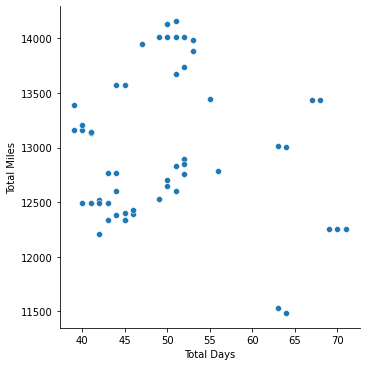

In [86]:
sns.relplot(x='Total Days',y='Total Miles',data=routeMetadata_df)

In [88]:
start_time = time.time()

# loop through all parks and save all possible routes per starting park in a dictionary
allRoutesByPark = {}
k = 0
for park in stadium_df['Park']:
    # dynamically create key
    key = park
    # calculate value
    value = find_route(park=park)
    allRoutesByPark[key] = value 
    k += 1

print("TOTAL Processing Time: %s seconds" % (time.time() - start_time))

Processing Time: 179.76097917556763 seconds
Processing Time: 158.18254971504211 seconds
Processing Time: 112.42718958854675 seconds
Processing Time: 108.64661383628845 seconds
Processing Time: 144.47572374343872 seconds
Processing Time: 132.8714337348938 seconds
Processing Time: 99.06375980377197 seconds
Processing Time: 91.18279600143433 seconds
Processing Time: 82.10356163978577 seconds
Processing Time: 201.81936264038086 seconds
Processing Time: 91.48349905014038 seconds
Processing Time: 116.8623833656311 seconds
Processing Time: 136.27123260498047 seconds
Processing Time: 99.21441078186035 seconds
Processing Time: 157.9979338645935 seconds
Processing Time: 62.63236999511719 seconds
Processing Time: 72.46843719482422 seconds
Processing Time: 70.80225992202759 seconds
Processing Time: 70.7506730556488 seconds
Processing Time: 68.45030689239502 seconds
Processing Time: 103.37945294380188 seconds
Processing Time: 76.04388499259949 seconds
Processing Time: 69.51869034767151 seconds
Proc

In [89]:
start_time = time.time()

# loop through all parks and save all possible routes per starting park in a dictionary
allRoutesByPark_with_pop = {}
k = 0
for park in stadium_df['Park']:
    # dynamically create key
    key = park
    # calculate value
    value = find_route_with_pop(park=park)
    allRoutesByPark_with_pop[key] = value 
    k += 1

print("TOTAL Processing Time: %s seconds" % (time.time() - start_time))

Processing Time: 113.21858382225037 seconds
Processing Time: 120.03008198738098 seconds
Processing Time: 80.96429204940796 seconds
Processing Time: 82.13318395614624 seconds
Processing Time: 84.20330762863159 seconds
Processing Time: 95.98336982727051 seconds
Processing Time: 93.37911438941956 seconds
Processing Time: 84.42779278755188 seconds
Processing Time: 75.20500469207764 seconds
Processing Time: 186.99206852912903 seconds
Processing Time: 85.33825540542603 seconds
Processing Time: 105.10897159576416 seconds
Processing Time: 116.88376712799072 seconds
Processing Time: 86.4957070350647 seconds
Processing Time: 118.98011922836304 seconds
Processing Time: 67.62469267845154 seconds
Processing Time: 94.42734384536743 seconds
Processing Time: 83.48631453514099 seconds
Processing Time: 92.69222331047058 seconds
Processing Time: 86.28117060661316 seconds
Processing Time: 135.29354763031006 seconds
Processing Time: 94.23451662063599 seconds
Processing Time: 83.73123073577881 seconds
Proce

In [90]:
pd.DataFrame(allRoutesByPark['Fenway Park'][0][1:], columns=["Index","Date","Time","Datetime","Team","Park","Address","Latitude","Longitude","Region","Dome Flag","Last Game of Homestead Flag","Double Header Flag",'Rain Probability','Distance From Last Park','Total Distance','Days Since Last Park','Total Days']).head(30)

,Index,Date,Time,Datetime,Team,Park,Address,Latitude,Longitude,Region,Dome Flag,Last Game of Homestead Flag,Double Header Flag,Rain Probability,Distance From Last Park,Total Distance,Days Since Last Park,Total Days
0,8,2022-04-15,7:00 pm,2022-04-15 19:00:00,Boston Red Sox,Fenway Park,"4 Yawkey Way, Boston, MA 02215",42.346613,-71.098817,Northeast,0,0,0,37.6,0.000000,0.000000,0,0
1,9,2022-04-16,7:00 pm,2022-04-16 19:00:00,Baltimore Orioles,Oriole Park at Camden Yards,"333 W. Camden Street, Baltimore, MD. 21201",39.285243,-76.620103,Northeast,0,0,0,36.9,357.776122,357.776122,1 days 00:00:00,1 days 00:00:00
2,10,2022-04-17,7:00 pm,2022-04-17 19:00:00,New York Mets,Citi Field,"Roosevelt Ave & 126th Street, New York, NY 11368",40.755350,-73.843219,Northeast,0,0,0,36.4,178.609057,536.385179,1 days 00:00:00,2 days 00:00:00
3,12,2022-04-19,7:00 pm,2022-04-19 19:00:00,Washington Nationals,Nationals Park,"1500 South Capitol Street SE, Washington, DC",38.870000,-77.010000,Northeast,0,0,1,34.6,212.617988,749.003167,2 days 00:00:00,4 days 00:00:00
4,15,2022-04-22,7:00 pm,2022-04-22 19:00:00,New York Yankees,Yankee Stadium,"E. 161 Street & River Ave., New York, NY 10451",40.819782,-73.929939,Northeast,0,0,0,37.3,211.743456,960.746623,3 days 00:00:00,7 days 00:00:00
5,16,2022-04-23,7:00 pm,2022-04-23 19:00:00,Philadelphia Phillies,Citizens Bank Park,"P.O. Box 7575, Philadelphia, PA 19101",39.952313,-75.162392,Northeast,0,0,0,42.8,88.312381,1049.059004,1 days 00:00:00,8 days 00:00:00
6,19,2022-04-26,7:00 pm,2022-04-26 19:00:00,Pittsburgh Pirates,PNC Park,"600 Stadium Circle, Pittsburgh, PA 15212",40.461503,-80.008924,Northeast,0,0,0,39.3,258.115444,1307.174448,3 days 00:00:00,11 days 00:00:00
7,20,2022-04-27,7:00 pm,2022-04-27 19:00:00,Atlanta Braves,SunTrust Park,"P.O. Box 4064, Atlanta, GA. 30302",33.746910,-84.391239,Southeast,0,0,0,28.6,522.836516,1830.010964,1 days 00:00:00,12 days 00:00:00
8,21,2022-04-28,7:00 pm,2022-04-28 19:00:00,Tampa Bay Rays,Tropicana Field,"1 Tropicana Drive, St. Petersburg, FL 33705",27.768487,-82.648191,Southeast,1,0,0,13.7,425.812804,2255.823769,1 days 00:00:00,13 days 00:00:00
9,22,2022-04-29,7:00 pm,2022-04-29 19:00:00,Miami Marlins,Marlins Park,"2269 NW 199th Street, Miami, FL 33056",25.954428,-80.238164,Southeast,1,0,0,24.4,194.353034,2450.176802,1 days 00:00:00,14 days 00:00:00


In [91]:
# Create DataFrame with metadata for each possible Fenway route
allRoutesMetadata = [['Route ID','Min Drive Miles','Max Drive Miles','Min Drive Minutes','Max Drive Minutes','Avg Drive Miles','Total Miles','Total Days']]
for key,value in allRoutesByPark.items():
    for i in range(1,len(value)-1,1):
        temp_df = pd.DataFrame(value[i][1:],columns=value[i][0])
        minDriveMiles = short_long_drives(temp_df, duration='short', dist_type='miles')
        maxDriveMiles = short_long_drives(temp_df, duration='long', dist_type='miles')
        minDriveMinutes = short_long_drives(temp_df, duration='short', dist_type='minutes')
        maxDriveMinutes = short_long_drives(temp_df, duration='long', dist_type='minutes')
        avgDriveMiles = totalMiles/29
        totalMiles = value[i][30][15]
        totalDays = value[i][30][17].days
        allRoutesMetadata.append([key + '-' + str(i),minDriveMiles,maxDriveMiles,minDriveMinutes,maxDriveMinutes,avgDriveMiles,totalMiles,totalDays])
    allRoutesMetadata_df = pd.DataFrame(allRoutesMetadata[1:],columns=allRoutesMetadata[0])

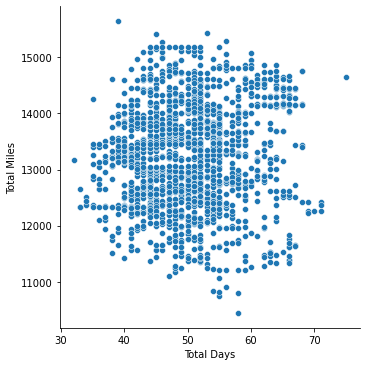

In [92]:
sns.relplot(x='Total Days',y='Total Miles',data=allRoutesMetadata_df)

## 5 Conclusion